In [32]:
import pandas as pd
import numpy as np
import time
from sklearn.svm import SVC
import RandomBinningFeatures
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import RidgeClassifier
from sklearn import metrics
import scipy
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
adult = pd.read_csv('adult.data.txt', header=None)

In [3]:
adult_test = pd.read_csv('adult.test.txt', header=None)

## Adult 

In [4]:
adult.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
adult_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [6]:
adult.columns = ['age','workclass','fnlwgt','education','education.num','marital.status','occupation','relationship','race','sex','capital.gain','capital.loss',
'hours.per.week','native.country','income']
adult_test.columns = ['age','workclass','fnlwgt','education','education.num','marital.status','occupation','relationship','race','sex','capital.gain','capital.loss',
'hours.per.week','native.country','income']

In [7]:
# adult.columns = adult2.columns
# adult_test.columns = adult2.columns

In [8]:
adult_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
age               16281 non-null int64
workclass         16281 non-null object
fnlwgt            16281 non-null int64
education         16281 non-null object
education.num     16281 non-null int64
marital.status    16281 non-null object
occupation        16281 non-null object
relationship      16281 non-null object
race              16281 non-null object
sex               16281 non-null object
capital.gain      16281 non-null int64
capital.loss      16281 non-null int64
hours.per.week    16281 non-null int64
native.country    16281 non-null object
income            16281 non-null object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


### Get object columns and do one-hot encoding

In [9]:
adult_str_col = adult.select_dtypes(exclude = ['int64', 'float64']).columns.values.tolist()

In [10]:
adult_str_col.remove('income')

In [11]:
adult_train_dummy = pd.get_dummies(adult[adult_str_col])

In [12]:
adult_test_dummy = pd.get_dummies(adult_test[adult_str_col])
#dummy_test = pd.get_dummies(adult_test_dummy)

In [13]:
adult_train_dummy['income'] = [1 if item == ' >50K' else 0 for item in adult['income']]
adult_test_dummy['income'] = [1 if item == ' >50K.' else 0 for item in adult_test['income']]

In [14]:
# check the unoverlapped values in training and test data 
for col in adult_train_dummy.columns:
    if col not in adult_test_dummy.columns:
        print(col)

native.country_ Holand-Netherlands


In [15]:
adult_test_dummy['native.country_ Holand-Netherlands'] = 0

In [16]:
adult_train_dummy.shape

(32561, 103)

In [17]:
adult_test_dummy.shape

(16281, 103)

In [18]:
adult_str_col.append('income')

In [19]:
adult_train_new = pd.concat([adult.drop(adult_str_col, axis=1), adult_train_dummy], axis=1)

In [20]:
adult_test_new = pd.concat([adult_test.drop(adult_str_col, axis=1).reset_index(drop=True), adult_test_dummy.reset_index(drop=True)], axis=1)

In [21]:
adult_test_new.shape

(16281, 109)

In [22]:
adult_train_new.to_csv('adult_train.csv', index=False)
adult_test_new.to_csv('adult_test.csv', index=False)

### Read the preprocessed data

In [23]:
train = pd.read_csv('adult_train.csv')
test = pd.read_csv('adult_test.csv')
train = train.reindex_axis(sorted(train.columns), axis=1).copy()
test = test.reindex_axis(sorted(test.columns), axis=1).copy()

In [24]:
X_train = train.drop('income', axis=1).values
y_train = [-1 if item == 0 else 1 for item in train['income']]
X_test = test.drop('income', axis=1).values
y_test = [-1 if item == 0 else 1 for item in test['income']]

In [25]:
def classification_err(y_test, y_pred):
    return (0.5 - np.dot(np.sign(y_test), y_pred)/len(y_test)/2)

### Random Fourier Features

In [26]:
start_time = time.time()
rbf_feature = RBFSampler(gamma=1, n_components=500)
rbf_feature.fit(X_train)
X_features_train = rbf_feature.transform(X_train)
X_features_test = rbf_feature.transform(X_test)
clf = RidgeClassifier(alpha=0.0001, solver='lsqr')
clf.fit(X_features_train, y_train) 
y_pred = clf.predict(X_features_test)
print("--- %s seconds ---" % (time.time() - start_time))
#score = metrics.accuracy_score(y_test, y_pred)
score = classification_err(y_test, y_pred)*100
print("error:   %0.7f" % score+'%')

--- 1.4292385578155518 seconds ---
error:   23.6226276%


### Random Binning Features

In [27]:
err = RandomBinningFeatures.RandomBinning.evaluate_random_binning(X_train, y_train, X_test, y_test, 30, 'classification')

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


--- 12.987390279769897 seconds ---
C = 975115; error_test = 23.60%


### SVM

In [28]:
start_time = time.time()
clf = SVC(random_state=42)
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))
score = classification_err(y_test, y_pred)*100
print("error:   %0.7f" % score+'%')

--- 548.6714055538177 seconds ---
error:   23.9665868%


### Plotting

In [40]:
#use random fourier feature
def plot_error_and_time(D,gamma=0.01,alpha=10.):
    times = []
    errs = [] 
    for d in D:
        start_time = time.time()
        rbfs = RBFSampler(gamma=gamma,n_components=d,random_state=42)
        Z = rbfs.fit(X_train)
        train_features = Z.transform(X_train)
        test_features = Z.transform(X_test)

        clf = RidgeClassifier(alpha=alpha, solver='svd')
        clf.fit(train_features, y_train) 
        y_pred = clf.predict(test_features)

        times.append(time.time() - start_time)
        errs.append(classification_err(y_test, y_pred)*100) 
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.plot(D, times)
    plt.xlabel("D")
    plt.ylabel("training and testing time(sec)")
    plt.subplot(122)
    plt.plot(D,errs)
    plt.xlabel("D")
    plt.ylabel("testing error rate(%)")

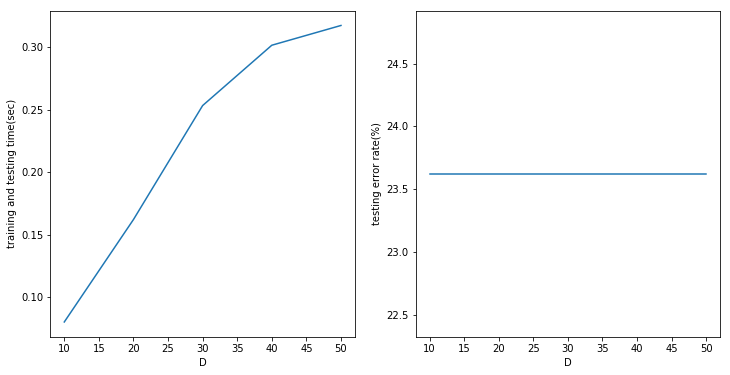

In [41]:
plot_error_and_time([10,20,30,40,50])

In [46]:
#use random binning feature
def plot_error_and_time(D,gamma=0.01,alpha=10.):
    times = []
    errs = [] 
    for d in D:
        start_time = time.time()
        rbfs = RandomBinningFeatures.RandomBinning.evaluate_random_binning(X_train, y_train, X_test, y_test, d, 'classification')
        times.append(time.time() - start_time)
        errs.append(rbfs) 
        
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.plot(D, times)
    plt.xlabel("P")
    plt.ylabel("training and testing time(sec)")
    plt.subplot(122)
    plt.plot(D,errs)
    plt.xlabel("P")
    plt.ylabel("testing error rate(%)")

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


--- 3.7052526473999023 seconds ---
C = 325114; error_test = 23.61%
--- 8.40346884727478 seconds ---
C = 650222; error_test = 23.61%
--- 13.415461301803589 seconds ---
C = 975107; error_test = 23.59%
--- 17.02515149116516 seconds ---
C = 1300169; error_test = 23.62%
--- 21.7538845539093 seconds ---
C = 1625304; error_test = 23.60%


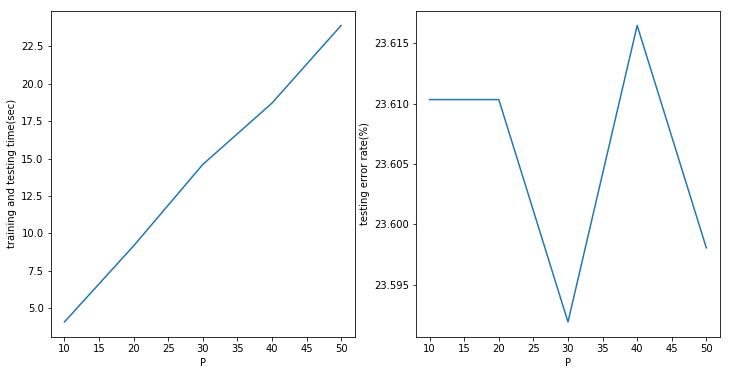

In [47]:
plot_error_and_time([10,20,30,40,50])